In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel

import pandas as pd

# Load data

In [2]:
data_schema = StructType([
    StructField('session_start_datetime',TimestampType(), False),
    StructField('user_id',IntegerType(), False),
    StructField('user_ip',IntegerType(), False),
    StructField('primary_video_id',IntegerType(), False),
    StructField('video_id',IntegerType(), False),
    StructField('vod_type',StringType(), False),
    StructField('session_duration',IntegerType(), False),
    StructField('device_type',StringType(), False),
    StructField('device_os',StringType(), False),
    StructField('player_position_min',LongType(), False),
    StructField('player_position_max',LongType(), False),
    StructField('time_cumsum_max',LongType(), False),
    StructField('video_duration',IntegerType(), False),
    StructField('watching_percentage',FloatType(), False)
])
final_stat = spark.read.csv(
    './output/train_data_full.csv', header=True, schema=data_schema
).cache()

assert(final_stat.count() == 7964397)

In [3]:
final_stat.limit(5).toPandas()

,session_start_datetime,user_id,user_ip,primary_video_id,video_id,vod_type,session_duration,device_type,device_os,player_position_min,player_position_max,time_cumsum_max,video_duration,watching_percentage
0,2018-07-01 00:00:02.135,21603820,27241033,9583642,9583642,svod,688,web,Windows_10,6940,6940,93,8198,0.0839
1,2018-07-01 00:00:02.232,35636970,10887511,24645936,24645936,advod,3174,mobile,android,599,3173,0,5297,0.5990
2,2018-07-01 00:00:06.961,78312976,15427448,25397362,23346676,advod,3054,tv,samsung,599,3052,3032,3052,1.0000
3,2018-07-01 00:00:11.044,122261599,12021384,5205267,22898606,svod,2400,tv,netcast,600,2400,2378,2638,0.9100
4,2018-07-01 00:00:14.054,53477088,65858458,14098190,14098190,advod,2481,tv,webos,137,4849,2316,5115,0.4850


In [4]:
final_stat.where('watching_percentage >= 0.5').count()

5536587

In [5]:
final_stat.where('watching_percentage < 0.5').count()

2427810

In [6]:
final_stat.select('user_id').distinct().count()

402009

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7df450ea58>]],
      dtype=object)

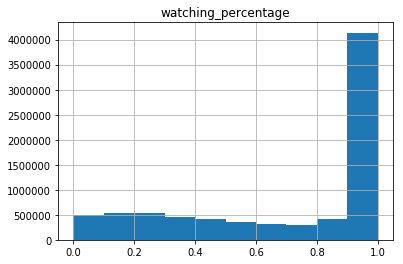

In [7]:
final_stat.select('watching_percentage').toPandas().hist()

## ALS

### train

In [8]:
ratings = (final_stat
    .select(
        'user_id',
        'primary_video_id',
        'watching_percentage',
    )
).repartition(200).cache()

In [9]:
%%time
ratings.count()

CPU times: user 32 ms, sys: 48 ms, total: 80 ms
Wall time: 2.53 s


7964397

In [10]:
%%time
als = ALS(rank=100, maxIter=10,
          implicitPrefs=True,
          regParam=1,
          alpha=50,
          userCol="user_id", itemCol="primary_video_id", ratingCol="watching_percentage",
          numUserBlocks=32, numItemBlocks=32,
          coldStartStrategy="drop")
model = als.fit(ratings)

CPU times: user 40 ms, sys: 8 ms, total: 48 ms
Wall time: 6min 31s


### predict

In [11]:
%%time
userRecsDf = model.recommendForAllUsers(10).cache()
userRecsDf.count()

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 44.1 s


In [12]:
userRecs = userRecsDf.toPandas()
userRecs.shape

(402009, 2)

In [13]:
userRecs[:2]

,user_id,recommendations
0,7340,"[(8967793, 0.9486003518104553), (14535101, 0.9..."
1,28577,"[(21146883, 0.9631668925285339), (762848, 0.94..."


In [14]:
predicted_dict = userRecs.set_index('user_id').to_dict('index')
predicted_dict = {user_id:[r[0] for r in recs['recommendations']] for user_id, recs in predicted_dict.items()}
len(predicted_dict)

402009

### save

In [15]:
sample_submission = pd.read_csv('./output/sample_submission_full.csv')

In [16]:
sample_submission['als_predicted_primary_video_id'] = sample_submission.user_id.apply(
    lambda user_id: ' '.join([str(v) for v in predicted_dict[user_id]]) if user_id in predicted_dict else None)

In [17]:
sample_submission[:10]

,user_id,primary_video_id,als_predicted_primary_video_id
0,1088,25397362 20236783 24633210 2677761 31588514 22...,None
1,28577,25397362 20236783 24633210 2677761 31588514 22...,21146883 762848 16385757 22575620 31648077 269...
2,188122,25397362 20236783 24633210 2677761 31588514 22...,14591932 26320644 26997030 27740348 3551683 31...
3,235599,25397362 20236783 24633210 2677761 31588514 22...,4889342 6597685 21757334 22328483 17487453 145...
4,274770,25397362 20236783 24633210 2677761 31588514 22...,30312899 1532356 27946137 31382698 28776964 68...
5,554364,25397362 20236783 24633210 2677761 31588514 22...,14496524 18775834 10735044 709139 5508300 1216...
6,564435,25397362 20236783 24633210 2677761 31588514 22...,30222725 192557 30291128 4460659 12153123 1986...
7,946127,25397362 20236783 24633210 2677761 31588514 22...,31588514 11538360 21426834 11653814 31148166 2...
8,955946,25397362 20236783 24633210 2677761 31588514 22...,32998109 23987196 19452297 26803805 1958224 13...
9,1223195,25397362 20236783 24633210 2677761 31588514 22...,22575620 5760990 33252778 1996490 28667563 370...


In [18]:
sample_submission['primary_video_id'] = sample_submission.als_predicted_primary_video_id.combine_first(
    sample_submission.primary_video_id)
del sample_submission['als_predicted_primary_video_id']

In [19]:
sample_submission.to_csv('./output/sample_submission_full_als.csv.gz',
                         header=True, index=False, compression='gzip')